In [2]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import glob
import librosa
import numpy as np
import librosa.display
import moviepy.editor as mp
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [3]:
AUDIO_DIR = f"{os.path.abspath('./../../')}/eNTERFACE05_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)

In [211]:
def calculate_spikes(data, percentange):
    mean = np.mean(data)
    threshold = mean + mean * percentange / 100
    num_spikes = 0

    for value in data:
        if value >= threshold:
            num_spikes += 1
    
    return num_spikes

In [215]:
def extract_features(audio_file, subject, gender, emotion, analysis=False):
    emotion_number = {
        'anger': 0,
        'disgust': 1,
        'fear': 2,
        'happiness': 3,
        'sadness': 4,
        'surprise': 5
    }

    file = audio_file.split(".")[-2].split("\\")[-1]

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    mfcc = librosa.feature.mfcc(y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels)
    rms = librosa.feature.rms(y)
    chroma_stft = librosa.feature.chroma_stft(y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spec_cont = librosa.feature.spectral_contrast(y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    if analysis:
        return [file, subject, gender, emotion, y, sr, mel_spect, mfcc, chroma_stft, rms, spec_cent,\
            spec_cont, spec_bw, spec_rolloff, zcr]

    features_str = f'{file} {subject} {gender} {emotion} {emotion_number[emotion]} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)}\
        {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_cont)} {np.mean(spec_bw)} {np.mean(spec_rolloff)} {np.mean(zcr)}  {np.var(zcr)} {np.std(zcr)} {calculate_spikes(np.concatenate(zcr), 100)}'

    for e in mfcc:
        features_str += f' {np.mean(e)}'

    return features_str.split()

In [218]:
def process_data(audio_dir, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    header = 'File Subject Gender Emotion Emotion_Id mel_mean mel_min mel_max mel_var mel_std mean_chroma_stft mean_rms mean_spectral_centroid mean_spectral_contrast mean_spectral_bandwidth mean_spectral_rolloff mean_zero_crossing_rate var_zero_crossing_rate std_zero_crossing_rate spikes_zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(header)

    print("Processing audio files from all subjects:")
    for file_path in tqdm(glob.glob(audio_dir+'/*/*/*/*.avi')):
        labels =  file_path.split('\\')
        # labels =  file_path.split('/')
        subject = labels[-4].split('_')[1]
        gender = labels[-4].split('_')[2]
        emotion = labels[-3]

        audio_file_path = file_path[:-3] + 'wav'
        # convert file type to wav
        if not os.path.isfile(audio_file_path):
            audio_clip = mp.VideoFileClip(file_path)
            audio_clip.audio.write_audiofile(audio_file_path)
        file_path = audio_file_path

        processed_data = extract_features(file_path, subject, gender, emotion)
        writer.writerow(processed_data)

In [219]:
process_data(AUDIO_DIR, EXTRACTED_FEATURES_FILE)

Processing audio files from all subjects:


100%|██████████| 1287/1287 [01:11<00:00, 17.98it/s]


# Feature Analysis

In [147]:
columns = ['File', 'Subject', 'Gender', 'Emotion', 'signal', 'sample_rate', 'mel_spec', 'mfcc', 'chroma_stft', 'rms', 'spec_cent', 'spec_cont', 'spec_bw', 'spec_rolloff', 'zcr']
df = pd.DataFrame(columns=columns)

for file_path in tqdm(glob.glob(AUDIO_DIR+"/subject_*_[a-z]/*/*/*.wav")):
    labels =  file_path.split('\\')
    # labels =  file_path.split('/')
    subject = int(labels[-4].split('_')[1])
    gender = labels[-4].split('_')[2]
    emotion = labels[-3]

    features = extract_features(file_path, subject, gender, emotion, analysis=True)

    df = df.append(pd.DataFrame(features, index=columns).transpose(), ignore_index=True)

df = df.sort_values(['Subject', 'Emotion'], ascending = (True, True))
df = df.set_index('Subject')
df

100%|██████████| 1287/1287 [01:11<00:00, 17.94it/s]


File Gender   Emotion  \
Subject                              
1         s1_an_1      m     anger   
1         s1_an_2      m     anger   
1         s1_an_3      m     anger   
1         s1_an_4      m     anger   
1         s1_an_5      m     anger   
...           ...    ...       ...   
43       s43_su_1      m  surprise   
43       s43_su_2      m  surprise   
43       s43_su_3      m  surprise   
43       s43_su_4      m  surprise   
43       s43_su_5      m  surprise   

                                                    signal sample_rate  \
Subject                                                                  
1        [0.00035997134, -0.0010580126, -0.002465626, -...       22050   
1        [-0.00027841155, 0.00018993257, 0.00018788749,...       22050   
1        [-0.004105932, -0.005565478, -0.0050745644, -0...       22050   
1        [0.0052672788, 0.007731445, 0.0069936556, 0.00...       22050   
1        [0.00071568514, 0.0011181713, 0.0004959308, 0....       22050   
...                                                    ...         ...   
43       [-0.0007337471, -0.0010952397, -0.00093488774,...       22050   
43       [0.00029972492, 8.2091035e-05, -5.6407756e-05,...       22050   
43       [0.00044551372, 0.00039270267, 0.00050553627, ...       22050   
43       [-0.00016639946, -0.0007042265, -0.00071378314...       22050   
43       [0.0005481963, 0.00091355614, 0.0010104153, 0....       22050   

                                                  mel_spec  \
Subject                                                      
1        [[0.002001118, 0.0017819229, 0.0017195621, 0.0...   
1        [[0.0024354756, 0.00069461006, 0.00033464364, ...   
1        [[0.00896601, 0.0026458544, 0.0009074437, 0.00...   
1        [[0.002444172, 0.0032212432, 0.002198903, 0.00...   
1        [[0.00064072805, 0.00046260562, 0.00048341657,...   
...                                                    ...   
43       [[0.00045935254, 0.00033422062, 0.0003531285, ...   
43       [[0.0006681229, 0.0007105833, 0.0013445498, 0....   
43       [[0.00055533997, 0.00045939942, 0.00027939508,...   
43       [[0.0011620879, 0.00054804597, 0.000130281, 0....   
43       [[7.0043236e-05, 7.209013e-05, 0.00040373008, ...   

                                                      mfcc  \
Subject                                                      
1        [[-429.37125, -428.35626, -430.707, -424.46725...   
1        [[-446.32922, -440.68665, -433.72247, -428.577...   
1        [[-433.5722, -433.8605, -435.92566, -434.57443...   
1        [[-418.07758, -419.15588, -418.8444, -416.2291...   
1        [[-415.10132, -410.86313, -411.89185, -414.013...   
...                                                    ...   
43       [[-556.62213, -557.5082, -565.61273, -565.381,...   
43       [[-572.7084, -574.88995, -573.1853, -572.02014...   
43       [[-564.65955, -566.0375, -567.7028, -567.41974...   
43       [[-583.5283, -582.31104, -583.82715, -581.8652...   
43       [[-559.0147, -557.6479, -557.0042, -558.11035,...   

                                               chroma_stft  \
Subject                                                      
1        [[0.5232388, 0.95512575, 0.65299016, 0.5713822...   
1        [[0.40890256, 0.1631425, 0.13072106, 0.1432946...   
1        [[0.3109331, 0.34250224, 0.3989865, 0.2839565,...   
1        [[0.52346027, 0.6483088, 0.38851443, 0.2679233...   
1        [[0.91101253, 0.33617514, 0.53662616, 0.485780...   
...                                                    ...   
43       [[0.9344214, 0.8426098, 0.79037523, 0.6503681,...   
43       [[0.3479489, 0.23913781, 0.26096517, 0.4073569...   
43       [[0.32854557, 0.6877214, 0.7483054, 0.94224614...   
43       [[0.74569565, 0.5831537, 0.39572564, 0.4585823...   
43       [[0.5864639, 0.6151637, 0.95284784, 0.93077624...   

                                                       rms  \
Subject                                                      
1        [

### Gender Distribution of Subjects

In [94]:
subjs_df = df.groupby(['Subject']).first()
print(f"Number of Subjects: {len(subjs_df)}")
print(f"Number of Male Subjects: {len(subjs_df.loc[subjs_df['Gender'] == 'm'])}")
print(f"Number of Female Subjects: {len(subjs_df.loc[subjs_df['Gender'] == 'f'])}")

Number of Subjects: 43
Number of Male Subjects: 36
Number of Female Subjects: 7


In [98]:
def signal_analysis(axs, i, emotion, signal, sample_rate):
    print(f'\tSample rate = {sample_rate}')
    print(f'\tSignal mean = {np.mean(signal):.5f}')
    print(f'\tSignal minimum = {np.std(signal):.5f}')
    print(f'\tSignal maximum = {np.std(signal):.5f}')
    print(f'\tSignal standard deviation = {np.std(signal):.5f}')
    print(f'\tSignal variance = {np.std(signal):.5f}')


    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    librosa.display.waveplot(signal, sr=sample_rate, max_sr=1000, alpha=0.25, color='r', ax=ax)
    ax.plot()

In [99]:
def mel_spec_analysis(fig, axs, i, emotion, mel_spec):
    print(f'\tMel-Spectogram mean = {np.mean(mel_spec):.5f}')
    print(f'\tMel-Spectogram minimum = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram maximum = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram standard deviation = {np.std(mel_spec):.5f}')
    print(f'\tMel-Spectogram variance = {np.std(mel_spec):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = ax.pcolormesh(mel_spec, cmap="magma")
    ax.set_title(emotion)
    fig.colorbar(im, ax=ax)

In [100]:
def mfcc_analysis(fig, axs, i, emotion, mfcc, sr):
    print(f'\tMFCC shape = {mfcc.shape}')
    print(f'\tMFCC mean = {np.mean(mfcc):.5f}')
    print(f'\tMFCC minimum = {np.std(mfcc):.5f}')
    print(f'\tMFCC maximum = {np.std(mfcc):.5f}')
    print(f'\tMFCC standard deviation = {np.std(mfcc):.5f}')
    print(f'\tMFCC variance = {np.std(mfcc):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [101]:
def chromogram_analysis(fig, axs, i, emotion, chromogram, sr):
    print(f'\tChromogram mean = {np.mean(chromogram):.5f}')
    print(f'\tChromogram minimum = {np.std(chromogram):.5f}')
    print(f'\tChromogram maximum = {np.std(chromogram):.5f}')
    print(f'\tChromogram standard deviation = {np.std(chromogram):.5f}')
    print(f'\tChromogram variance = {np.std(chromogram):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    im = librosa.display.specshow(chromogram, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [102]:
def spec_analysis(axs, i, emotion, spec_cent, spec_bw, spec_rolloff, y, sr):
    spectral_centroids = minmax_scale(np.concatenate(spec_cent))
    print(f'\tSpectral Centroids mean = {np.mean(spectral_centroids):.5f}')
    spec_bw = minmax_scale(np.concatenate(spec_bw), config.scale_range)
    print(f'\tSpectral Bandwidth mean = {np.mean(spec_bw):.5f}')
    spectral_rolloff = minmax_scale(np.concatenate(spec_rolloff), config.scale_range)
    print(f'\tSpectral Rolloff mean = {np.mean(spectral_rolloff):.5f}')
    
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)

    librosa.display.waveplot(y, sr=sr, alpha=0.25, ax=ax)
    ax.plot(t, spectral_centroids, color='b', label="Spectral Centroids")
    ax.plot(t, spec_bw, color='g', label="Spectral Bandwidth")
    ax.plot(t, spectral_rolloff, color='r', label="Spectral Rolloff")
    ax.legend()
    ax.plot()

In [103]:
def rmse_analysis(axs, i, emotion, rmse):
    rmse = minmax_scale(np.concatenate(rmse), config.scale_range)
    print(f'\tRMSE mean = {np.mean(rmse):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(rmse)

In [104]:
def zcr_analysis(axs, i, emotion, zcrs):
    zcrs = minmax_scale(np.concatenate(zcrs), config.scale_range)
    print(f'\tZero Crossing Rate mean = {np.mean(zcrs):.5f}')

    ax = axs[0 if i < 3 else 1, i if i < 3 else i - 3]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(zcrs)

In [108]:
def audio_analsys(df):
    sig_fig, sig_axs = plt.subplots(2, 3, figsize=(20,8))
    mel_fig, mel_axs = plt.subplots(2, 3, figsize=(20,8))
    mfcc_fig, mfcc_axs = plt.subplots(2, 3, figsize=(20,8))
    chrom_fig, chrom_axs = plt.subplots(2, 3, figsize=(20,8))
    spec_fig, spec_axs = plt.subplots(2, 3, figsize=(20,8))
    rmse_fig, rmse_axs = plt.subplots(2, 3, figsize=(20,8))
    zcr_fig, zcr_axs = plt.subplots(2, 3, figsize=(20,8))

    sig_fig.suptitle("Signal Waveplot")
    mel_fig.suptitle("Log-Mel Magnitude Spectrogram")
    mfcc_fig.suptitle("Mel-Frequency Cepstral Coefficients Spectrogram")
    chrom_fig.suptitle("Chromogram Spectrogram")
    spec_fig.suptitle("Spectral Spectrogram")
    rmse_fig.suptitle("Root Mean Square Energy Waveplot")
    zcr_fig.suptitle("Zero Crossing Rate Waveplot")

    for ax in mel_axs.flat:
        ax.set(xlabel="Time (sample)", ylabel="Log-Mel Bins (mel)")

    for i in range(len(mel_axs.flat)):
        sig_axs.flat[i].label_outer()
        mel_axs.flat[i].label_outer()
        mfcc_axs.flat[i].label_outer()
        chrom_axs.flat[i].label_outer()
        spec_axs.flat[i].label_outer()
        rmse_axs.flat[i].label_outer()
        zcr_axs.flat[i].label_outer()

    for num_fig, data in enumerate(df.iterrows()):
        if num_fig > 5:
            break
            
        subject, features = data
        file, emotion, gender, signal, sample_rate, mel_spec, mfcc, chromogram, rmse, spec_cent, spec_cont, spec_bw, spec_rolloff, zcrs = features

        print(f"Data analysis for Subject {subject} and emotion {emotion} ({file}):")

        signal_analysis(sig_axs, num_fig, emotion, signal, sample_rate)
        mel_spec_analysis(mel_fig, mel_axs, num_fig, emotion, mel_spec)
        mfcc_analysis(mfcc_fig, mfcc_axs, num_fig, emotion, mfcc, sample_rate)
        chromogram_analysis(chrom_fig, chrom_axs, num_fig, emotion, chromogram, sample_rate)
        spec_analysis(spec_axs, num_fig, emotion, spec_cent, spec_bw, spec_rolloff, signal, sample_rate)
        rmse_analysis(rmse_axs, num_fig, emotion, rmse)
        zcr_analysis(zcr_axs, num_fig, emotion, zcrs)
        print("\n")

## Taking one subject (male) and one file per emotion

Data analysis for Subject 1 and emotion m (s1_an_1):
	Sample rate = 22050
	Signal mean = 0.00024
	Signal minimum = 0.15688
	Signal maximum = 0.15688
	Signal standard deviation = 0.15688
	Signal variance = 0.15688
	Mel-Spectogram mean = 5.47025
	Mel-Spectogram minimum = 53.24934
	Mel-Spectogram maximum = 53.24934
	Mel-Spectogram standard deviation = 53.24934
	Mel-Spectogram variance = 53.24934
	MFCC shape = (20, 147)
	MFCC mean = -10.09831
	MFCC minimum = 54.86871
	MFCC maximum = 54.86871
	MFCC standard deviation = 54.86871
	MFCC variance = 54.86871
	Chromogram mean = 0.40250
	Chromogram minimum = 0.31185
	Chromogram maximum = 0.31185
	Chromogram standard deviation = 0.31185
	Chromogram variance = 0.31185
	Spectral Centroids mean = 0.30606
	Spectral Bandwidth mean = 0.46527
	Spectral Rolloff mean = 0.50089
	RMSE mean = 0.37606
	Zero Crossing Rate mean = 0.27523


Data analysis for Subject 1 and emotion m (s1_di_1):
	Sample rate = 22050
	Signal mean = 0.00024
	Signal minimum = 0.12509
	S

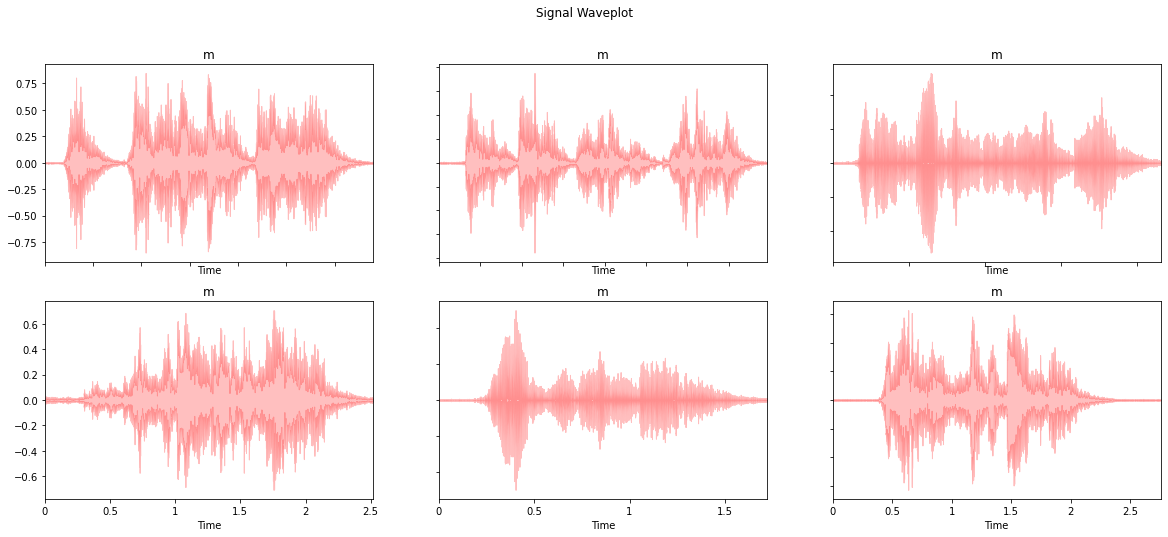

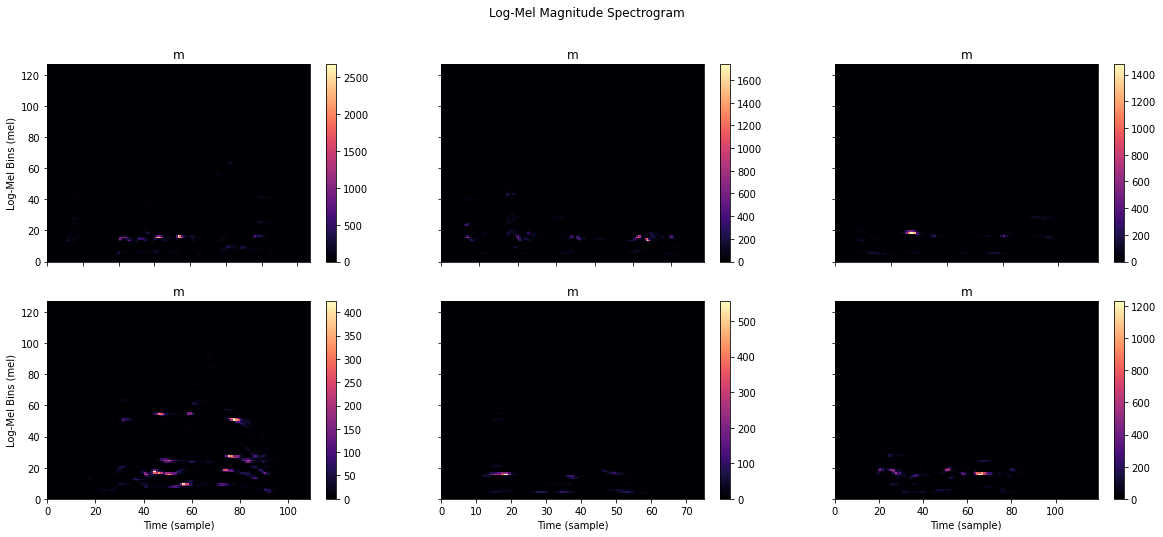

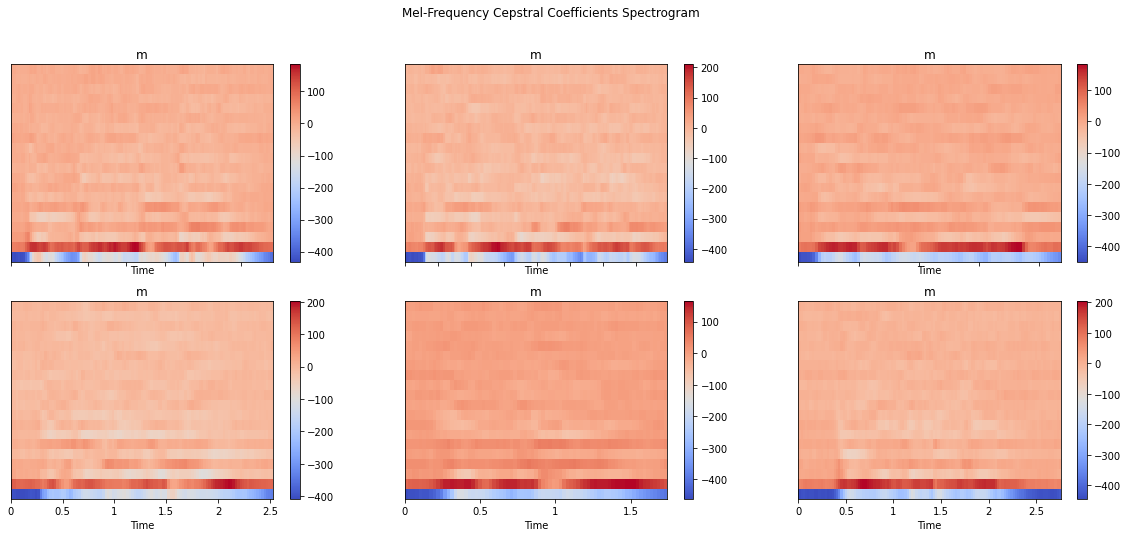

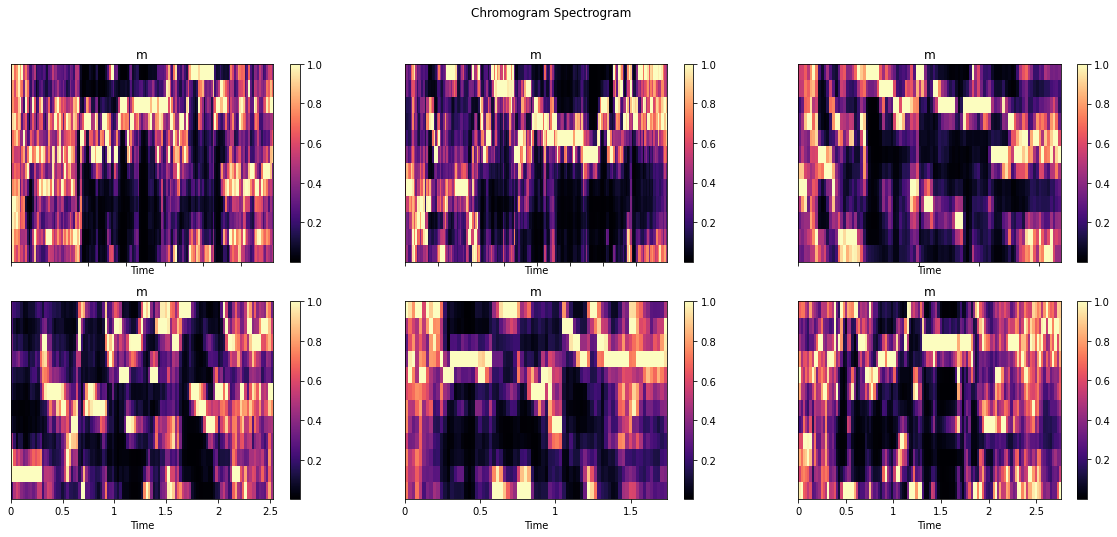

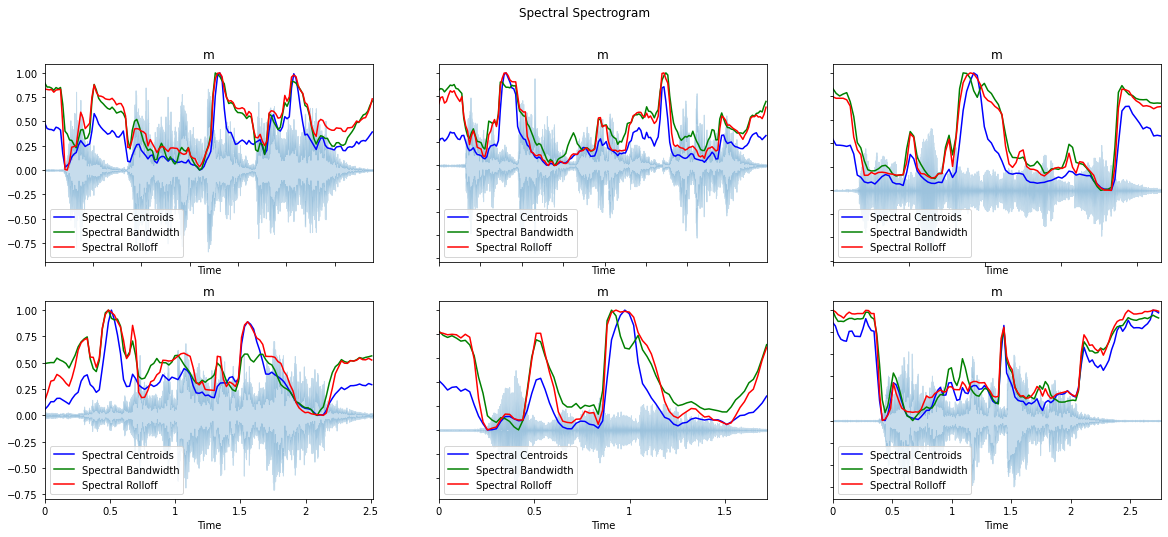

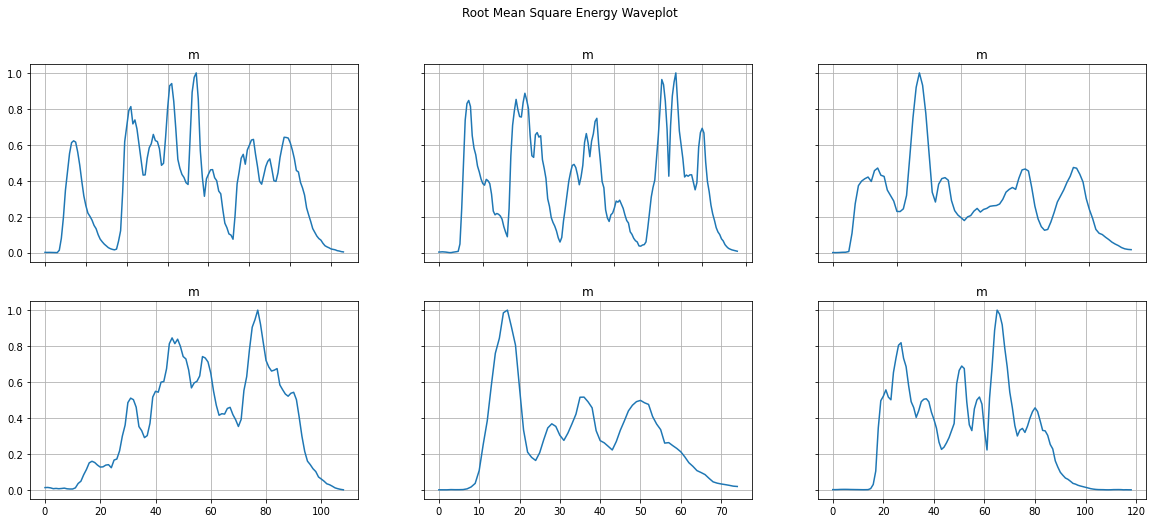

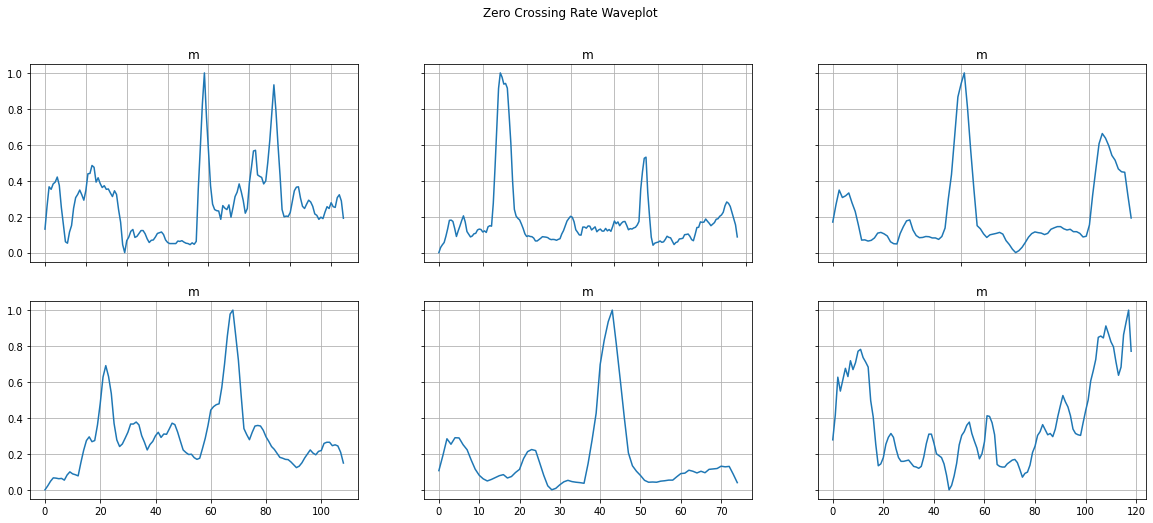

In [109]:
subj_1_sent_1 = df.loc[df['File'].str.contains(r's1_([a-z]*)_1', regex = True)]

audio_analsys(subj_1_sent_1)

# Single Feature Analysis

In [204]:
sns.set_theme(style="white")
colors = ['b', 'g', 'r', 'y', 'k', 'm', 'c', 'w']

def analyse_feature(df, feature, gender, normalize, spike_perc):
    grid = plt.GridSpec(6, 1, wspace=.1, hspace=.2)
    fig = plt.figure(figsize=(20,28), tight_layout=True)
    fig.suptitle(f"{feature} Analysis, 5 Subjects ({gender}), 1 Sentence", y=0.90, fontsize=18)
    emotions = {'an': 'anger', 'ha': 'happiness', 'sa': 'sadness', 'di': 'disgust', 'fe': 'fear', 'su': 'surprise'}
    threshold = 0.05

    for i, emotion in enumerate(emotions):
        subjs_data = df.loc[df['File'].str.contains(f"s*_{emotion}_1", regex = True) & df['Gender'].str.contains(gender)][:5]
        ax = plt.subplot(grid[i, :])
        ax.set_title(emotions[emotion])

        for i, data in enumerate(subjs_data.iterrows()):
            subj, data = data
            color = colors[i]
            zcr = np.concatenate(np.array(data[feature]))
            if normalize:
                threshold = 0.1
                zcr = minmax_scale(zcr, config.scale_range)
            num_spikes = calculate_spikes(zcr, spike_perc)
            mean = np.mean(zcr)
            var = np.var(zcr)
            std = np.std(zcr)
            label = f"Subject {subj}, Mean: {mean:.03f}, Var: {var:.03f}, Std: {std:.03f}, Spikes: {num_spikes}"
            x = np.arange(len(zcr))
            ax.plot(zcr, f'{color}-', label=label)
            ax.fill_between(x, zcr + threshold, zcr - threshold, color=color, alpha=0.2)
        ax.legend()

    plt.show()

## Zero Crossing Rate Analysis

### For each Emotion take 1 Sentence of 5 Male Subjects
#### Feature Unnormalized

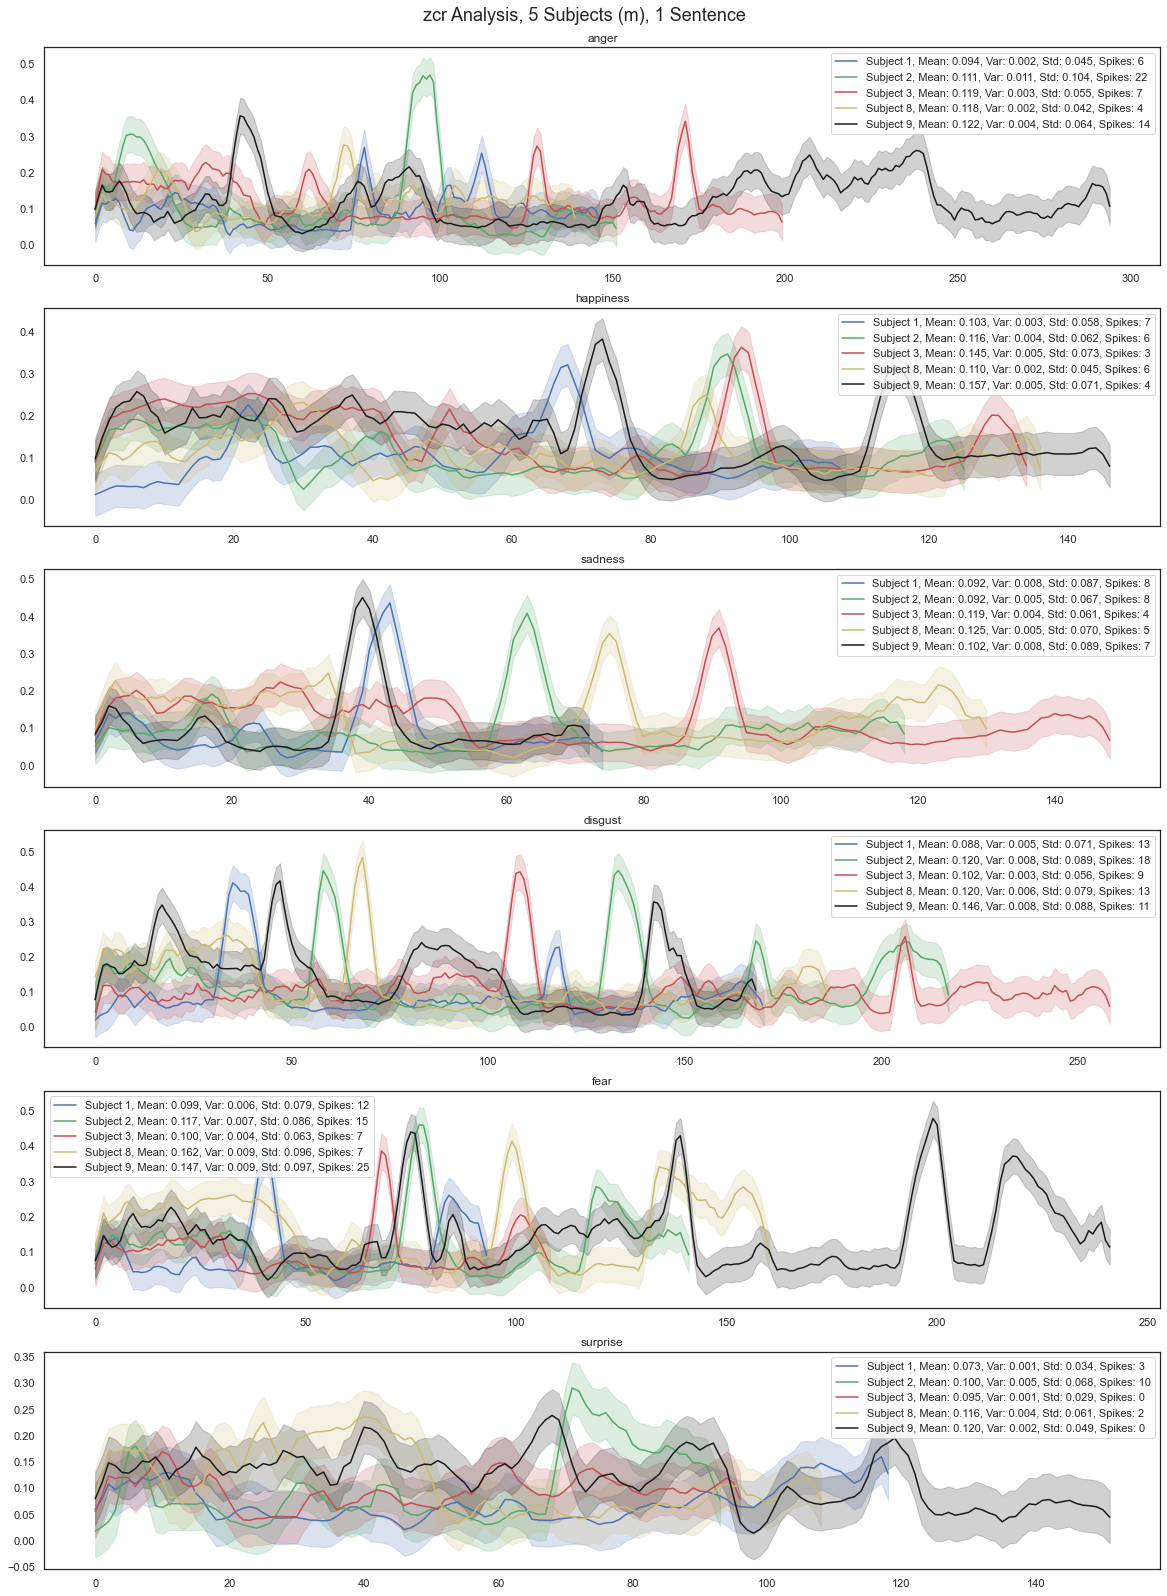

In [205]:
analyse_feature(df, 'zcr', 'm', False, 100)

#### Feature Normalized

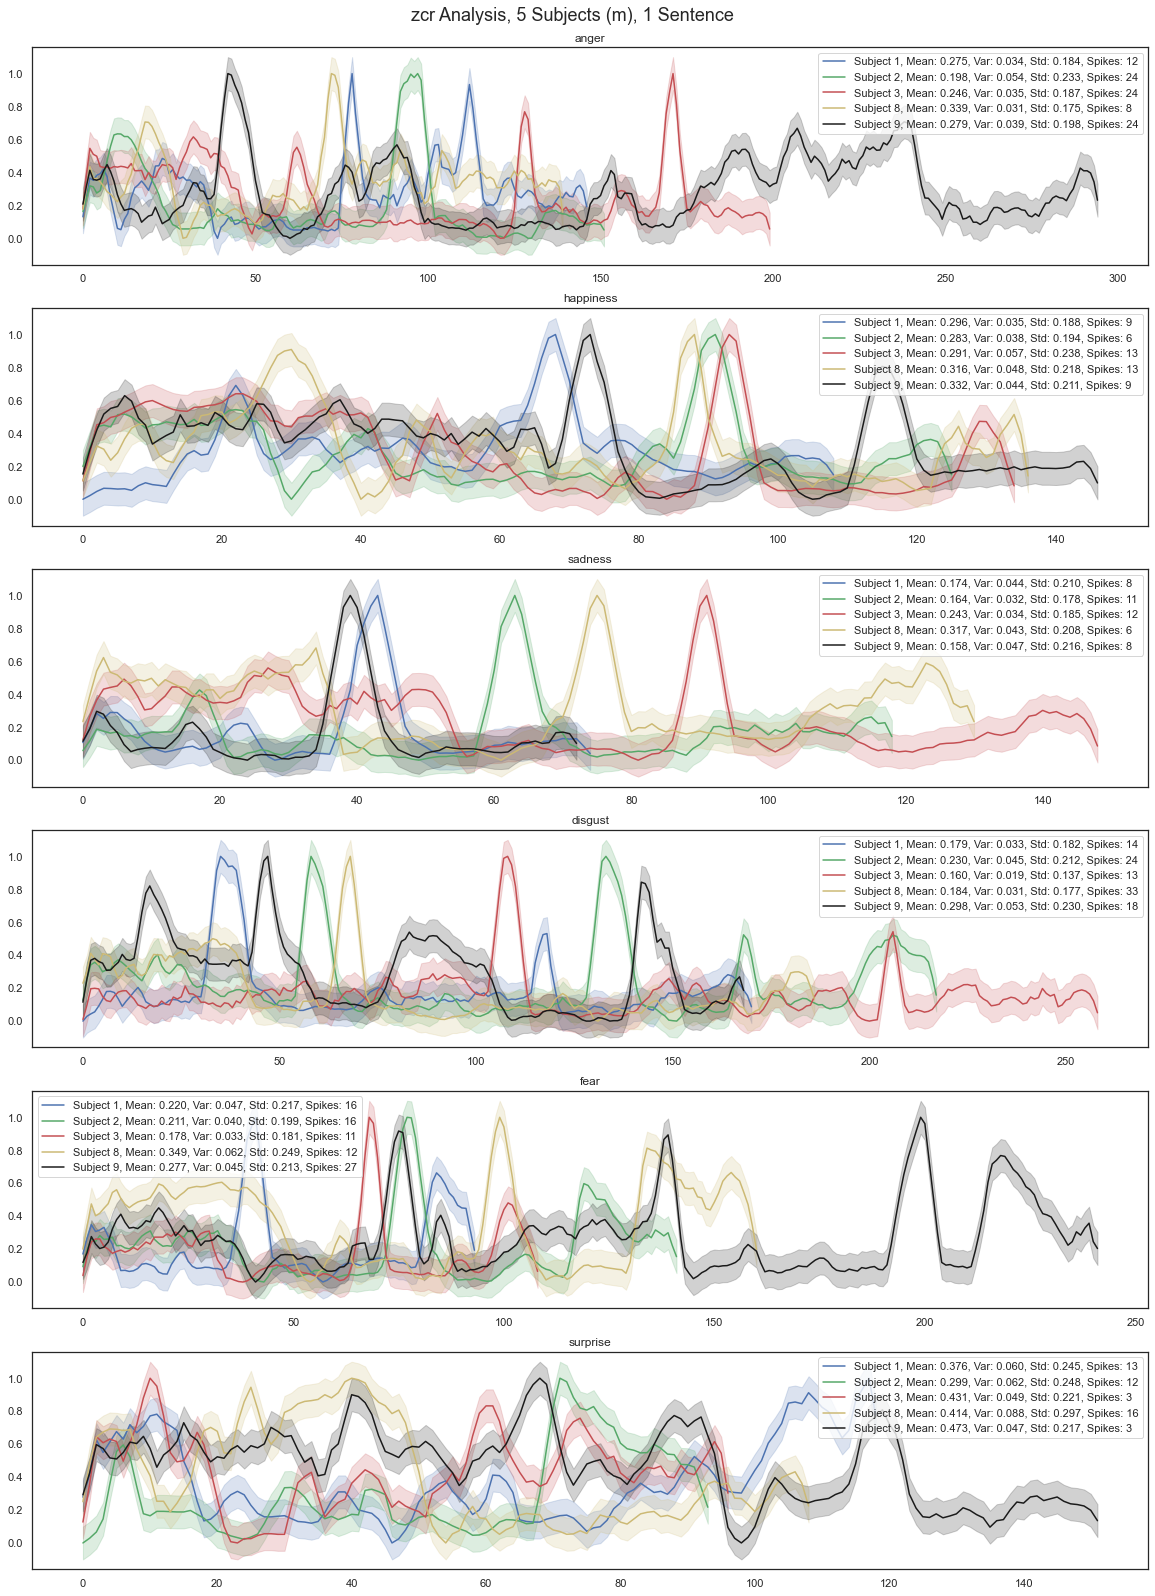

In [206]:
analyse_feature(df, 'zcr', 'm', True, 100)

### For each Emotion take 1 Sentence of 5 Female Subjects
#### Feature Unnormalized

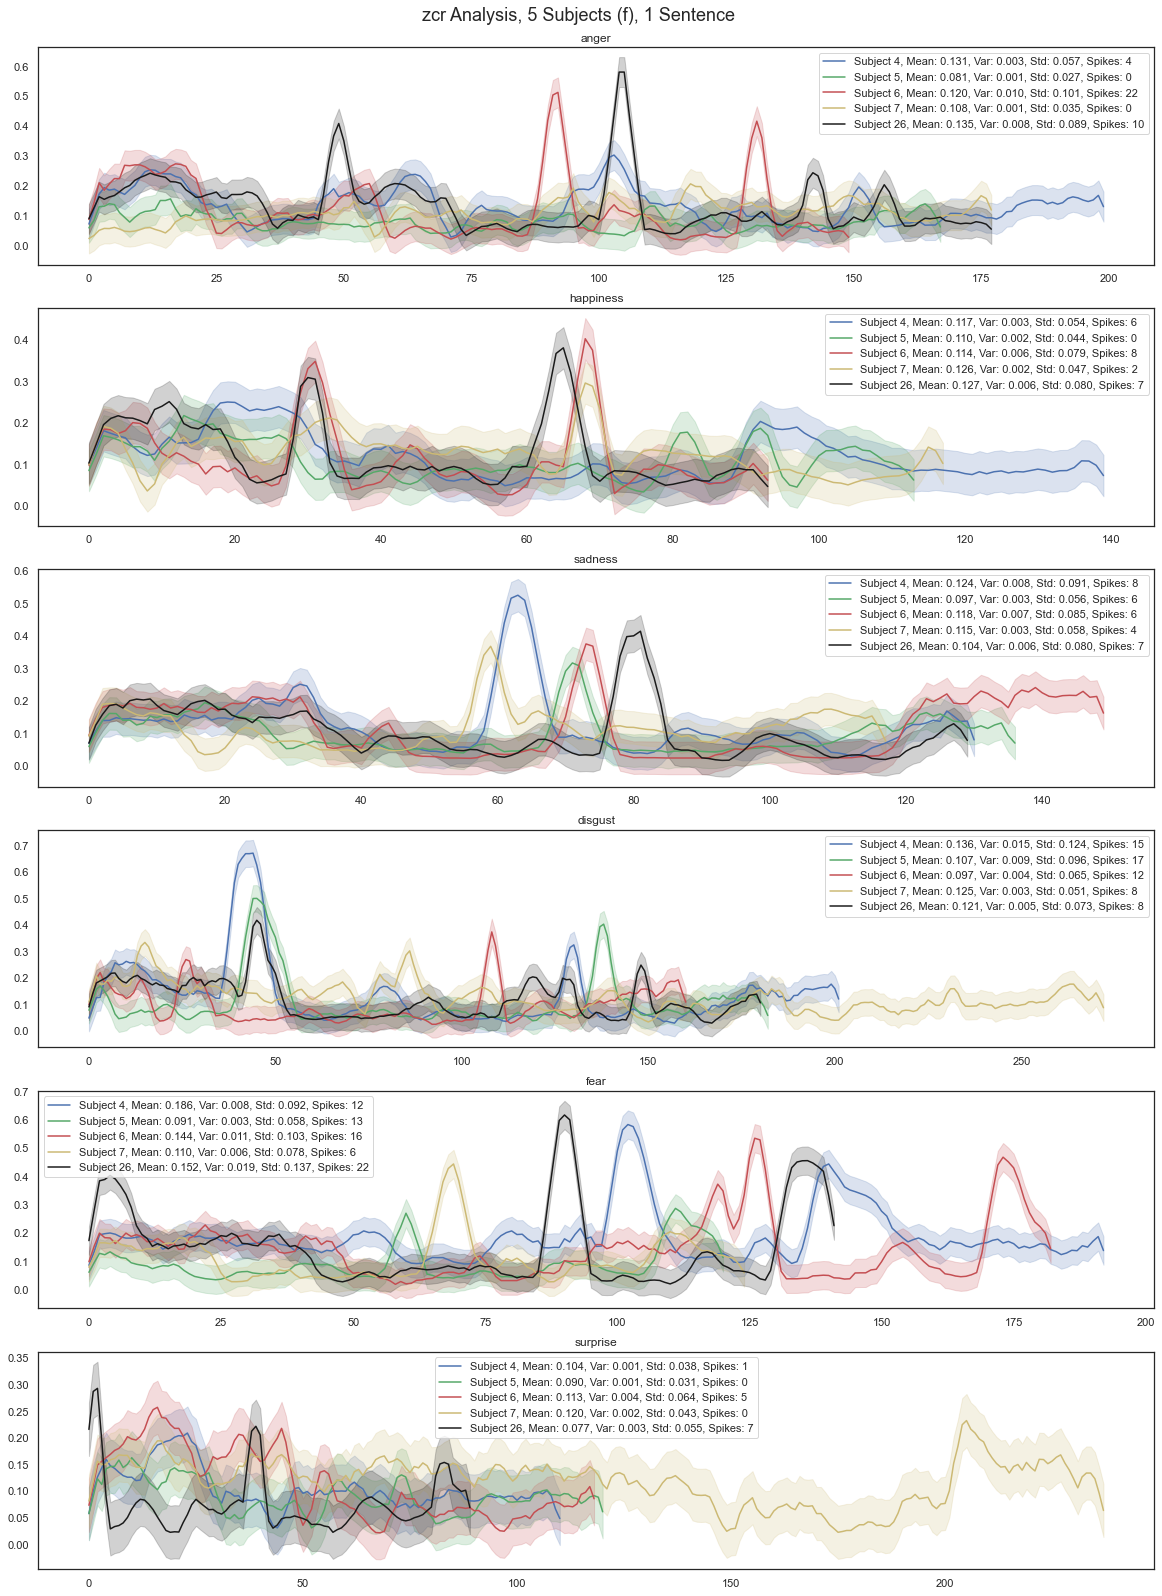

In [207]:
analyse_feature(df, 'zcr', 'f', False, 100)

#### Feature Normalized

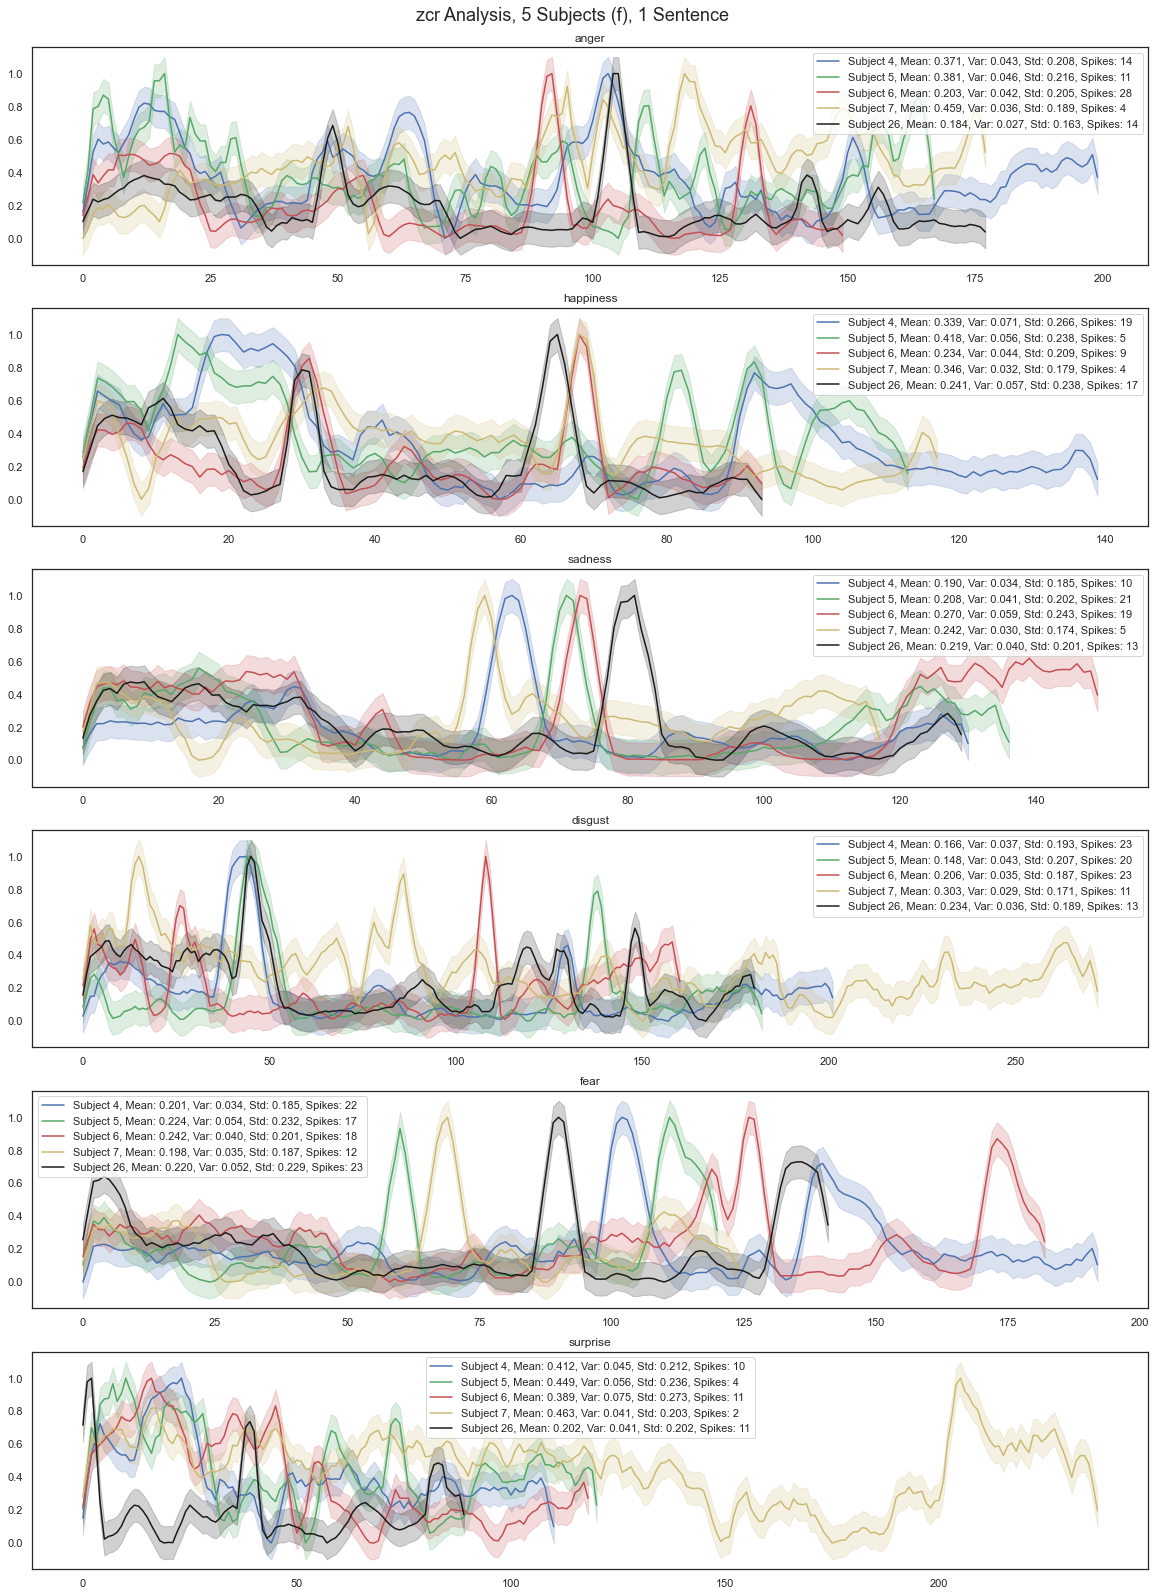

In [210]:
analyse_feature(df, 'zcr', 'f', True, 100)

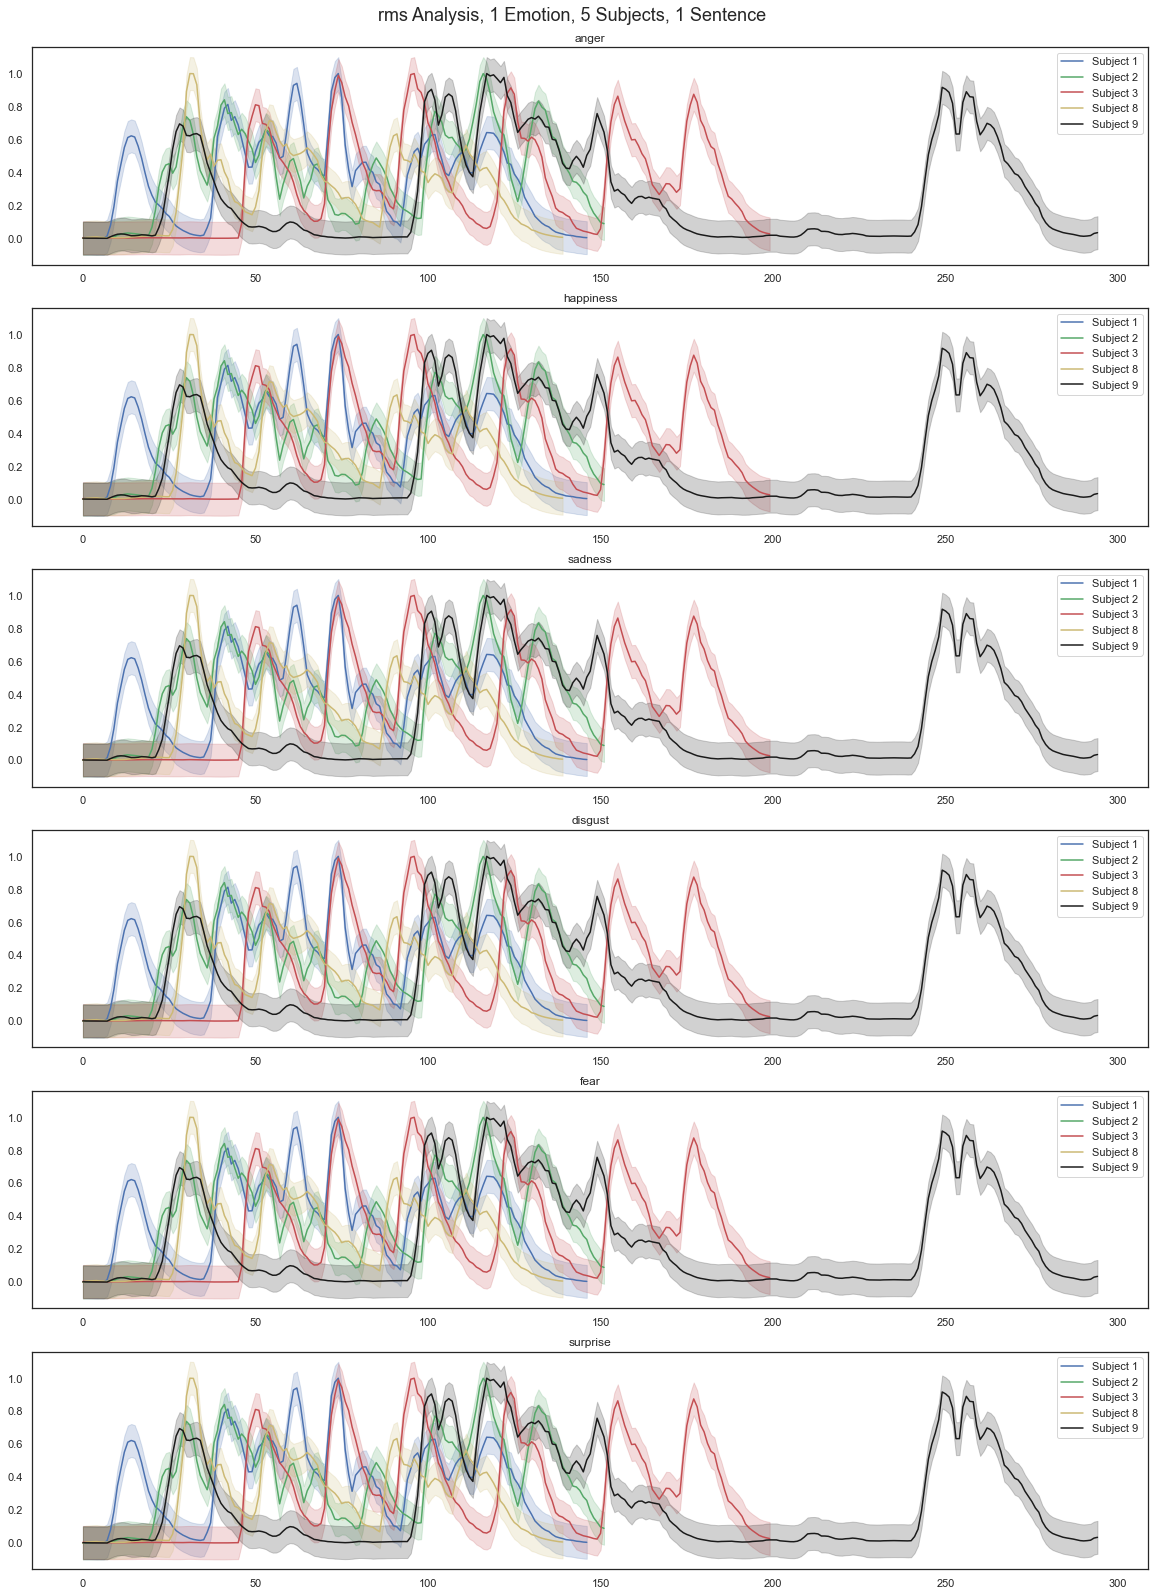

In [143]:
analyse_feature(df, 'rms')